In [1]:
import torch
import numpy as np

from utils.utils import *
from utils.dataloader import *
from utils.nop import *

import matplotlib.pyplot as plt

/home/marlon/miniconda3/envs/torch39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data and model location
data_path = 'data/era5_Santos_2022-2023.nc'
bath_path = 'data/era5_Santos_2022-2023_bath.nc'

model_path = 'models/model_nm250_1000_r500000.0_w16_kw18_d5.pt'

device = torch.device('cuda')

In [3]:
# Load model
model_data = torch.load(model_path, map_location=device)
pars = model_data['pars']

model = KernelNN(pars['model']['width'], pars['model']['kernel_width'], pars['model']['depth'], 3, in_width=3, out_width=1).to(device)
model.load_state_dict(model_data['model'])
model.eval()

KernelNN(
  (fc1): Linear(in_features=3, out_features=16, bias=True)
  (conv1): NNConv_old(16, 16)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)

In [4]:
# Case for evaluation
test_case = 90
n_vertices = 1000
n_neighbors = 0
radius = 500.e3

In [5]:
# Load data and run model
d = data_loader(data_path,bath_path)
test_data = d.sample_graph(n_vertices, test_case, radius=500000, n_connections=0, validation=True, seed=None).to(device)

X = test_data.coords
F = test_data.x.cpu().detach().numpy()
G_t = test_data.y.cpu().detach().numpy()

with torch.no_grad():
    G_p = model(test_data).cpu().detach().numpy()[:,0]

F[:,0:2] = F[:,0:2]/d.wind_norm
G_t = F/d.

Text(0.5, 1.0, 'SHWW (real - pred)')

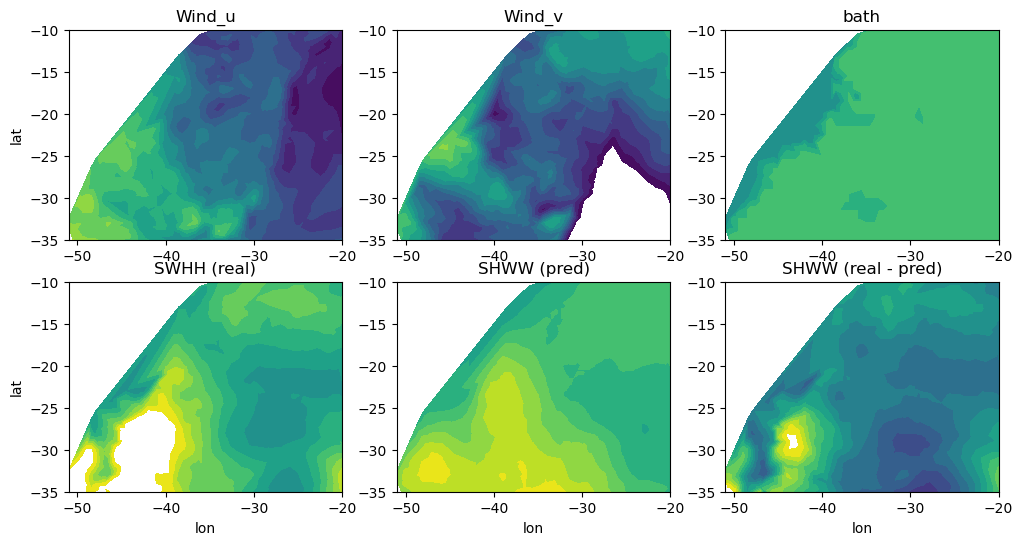

In [8]:
# Plot results
n_contours = 16

plt.figure(figsize=(12,6))

wind_max = np.max(np.abs(F[:,0:2]))
wave_max = np.max((np.max(np.abs(G_t)),np.max(np.abs(G_p))))

contours = 3*np.linspace(-1,1,n_contours)

plt.subplot(2,3,1)
plt.tricontourf(X[:,0],X[:,1],F[:,0],contours)
plt.title('Wind_u')
plt.ylabel('lat')

plt.subplot(2,3,2)
plt.tricontourf(X[:,0],X[:,1],F[:,1],contours)
plt.title('Wind_v')

plt.subplot(2,3,3)
plt.tricontourf(X[:,0],X[:,1],F[:,2],contours)
plt.title('bath')

plt.subplot(2,3,4)
plt.tricontourf(X[:,0],X[:,1],G_t,contours)
plt.title('SWHH (real)')
plt.xlabel('lon')
plt.ylabel('lat')

plt.subplot(2,3,5)
plt.tricontourf(X[:,0],X[:,1],G_p,contours)
plt.xlabel('lon')
plt.title('SHWW (pred)')

plt.subplot(2,3,6)
plt.tricontourf(X[:,0],X[:,1],G_t-G_p,contours)
plt.xlabel('lon')
plt.title('SHWW (real - pred)')

In [7]:
# Print metrics
def ioa(p,o):
    p = p.flatten()
    o = o.flatten()

    return 1 - (np.sum(np.square(o-p))/np.sum(np.square(np.abs(p-np.mean(o))+np.abs(o-np.mean(o)))))

print(f'MSE: {np.mean(np.square(y_p-y_gt))}')
print(f'MAE: {np.mean(np.abs(y_p-y_gt))}')
print(f'IOA: {ioa(y_gt,y_p)}')

NameError: name 'y_p' is not defined

In [ ]:
# Plot loss during training
plt.semilogy(model_data['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')